In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 2

##-------------

train_mu = [ 0.0, 1.0 ]



train_rho = [ [-0.6] ]






train_sig = [ 1.0, 1.5 ]


##-------------


true_mu = [ 0.2, 0.8 ]






true_rho  = [ [-0.6] ]



true_sig = [ 0.9, 1.3 ]



#--- nominal
resolution = [ 0.5, 0.8  ]

#--- poor
#resolution = [ 1.0, 1.6  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                



ngen_train = 4000000
ngen_true =  400000




of_niter = 5

learning_rate_setval = 0.0005


epochs_setval = 40

batch_size_setval = int( ngen_true )



output_dir = 'toy-study6b-2d'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    1.500 *   -0.600 =  -0.9000
   1,  1 : diagonal    2.2500



 True covariance:
   0,  0 : diagonal    0.8100
   0,  1 :              0.900 *    1.300 *   -0.600 =  -0.7020
   1,  1 : diagonal    1.6900


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.440000
True covariance determinant:   0.876096





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.   -0.9 ]
 [-0.9   2.25]]

 Train covariance inverse
[[1.5625     0.625     ]
 [0.625      0.69444444]]

 Train covariance inverse test
[[ 1.00000000e+00 -3.82410153e-17]
 [-5.55111512e-17  1.00000000e+00]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.81  -0.702]
 [-0.702  1.69 ]]

 True covariance inverse
[[1.92901235 0.80128205]
 [0.80128205 0.92455621]]

 True covariance inverse test
[[ 1.00000000e+00  3.80221824e-17]
 [-5.90695584e-17  1.00000000e+00]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : toy-study6b-2d/config.txt

2023-12-14 16:11:43.362500

ngen_train 4000000
ngen_true  400000
of_niter   5
ndim       2
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  400000


train_mu : [0.0, 1.0]
train_rho : [[-0.6]]
train_sig : [1.0, 1.5]
train_cov : [[ 1.   -0.9 ]
 [-0.9   2.25]]


true_mu : [0.2, 0.8]
true_rho : [[-0.6]]
true_sig : [0.9, 1.3]
true_cov : [[ 0.81  -0.702]
 [-0.702  1.69 ]]


resolution : [0.5, 0.8]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

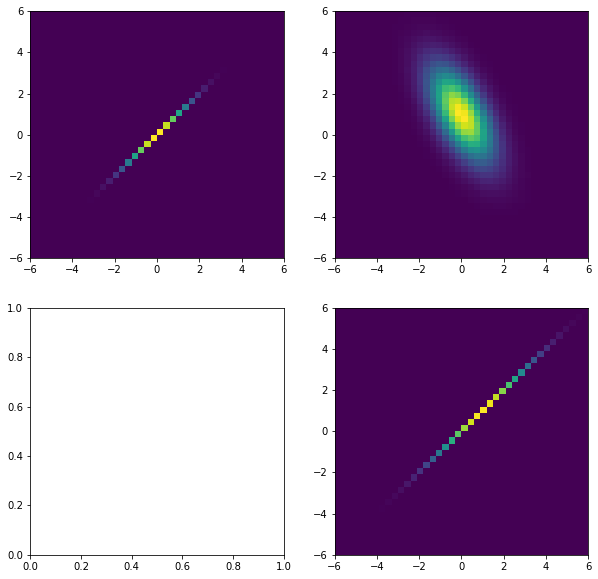

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

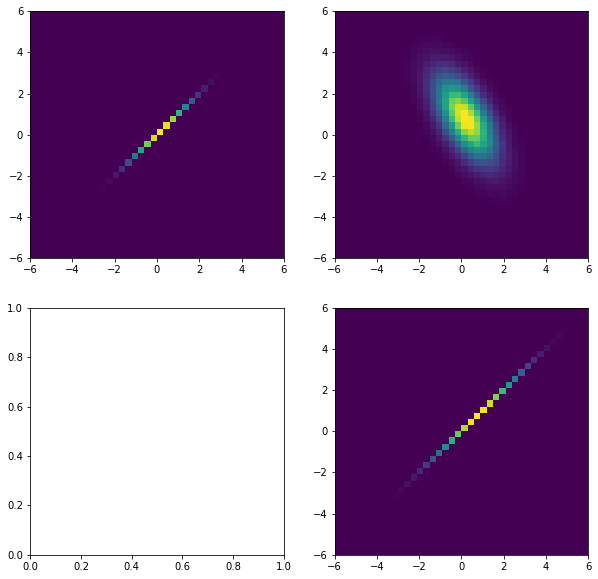

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

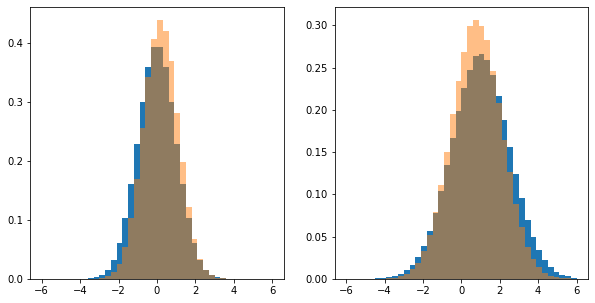

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [19]:
inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-14 16:11:44.872942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:11:44.898308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:11:44.898610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:11:44.902306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-14 16:11:44.902553: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [20]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [21]:
%%time


verbose = True






of_return_dict = of.omnifold6b( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold6b


  shape of theta0_S : (4000000, 2)
  shape of theta_unknown_S : (400000, 2)
  shape of xvals_1 :  (4400000, 2)



  shape of labels0 : (4000000,)
  shape of labels_unknown : (400000,)
  shape of yvals_1 :  (4400000,)



  shape of theta0_G : (4000000, 2)
  shape of xvals_2 :  (8000000, 2)
  shape of yvals_2 :  (8000000,)

 batch size setval  400000
 learning rate setval  0.000500
 epochs setval  40




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-14 16:11:49.108892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 16:11:49.113052: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9fcbe42410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 16:11:49.113065: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-14 16:11:49.116937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-14 16:11:49.214716: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 8ms/step - loss: 0.6938 - accuracy: 0.5087
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5604
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5098
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5323
Epoch 5/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5144
             done pretraining.
Epoch 1/80
9/9 [==============================] - 1s 28ms/step - loss: 0.1258 - accuracy: 0.3690 - val_loss: 0.1259 - val_accuracy: 0.3683
Epoch 2/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.3552 - val_loss: 0.1255 - val_accuracy: 0.3350
Epoch 3/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1250 - accuracy: 0.3220 - val_loss: 0.1252 - val_accuracy: 0.3086
Epoch 4/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1248

Epoch 56/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2561 - val_loss: 0.1247 - val_accuracy: 0.2569
Epoch 57/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2566 - val_loss: 0.1247 - val_accuracy: 0.2565
Epoch 58/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2572 - val_loss: 0.1247 - val_accuracy: 0.2556
Epoch 59/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2580 - val_loss: 0.1247 - val_accuracy: 0.2563
Epoch 60/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2568 - val_loss: 0.1247 - val_accuracy: 0.2562
Epoch 61/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1244 - accuracy: 0.2576 - val_loss: 0.1247 - val_accuracy: 0.2555
Epoch 62/80
9/9 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.2547 - val_loss: 0.1247 - val_accuracy: 0.2578
Epoch 63/80
9/9 [===

15/15 [==============================] - 0s 12ms/step - loss: 0.6875 - accuracy: 0.3972 - val_loss: 0.6874 - val_accuracy: 0.3970
Epoch 30/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.3972 - val_loss: 0.6874 - val_accuracy: 0.3970
Epoch 31/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6875 - accuracy: 0.3973 - val_loss: 0.6874 - val_accuracy: 0.3970
Epoch 32/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6875 - accuracy: 0.3972 - val_loss: 0.6874 - val_accuracy: 0.3969
Epoch 33/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.3972 - val_loss: 0.6874 - val_accuracy: 0.3970
Epoch 34/80
15/15 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.3971 - val_loss: 0.6874 - val_accuracy: 0.3969
Epoch 35/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6875 - accuracy: 0.3971 - val_loss: 0.6874 - val_accuracy: 0.3969
Epoch 36/80
15/15 

15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5460
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 25ms/step - loss: 0.1262 - accuracy: 0.2815 - val_loss: 0.1259 - val_accuracy: 0.3899
Epoch 2/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.3958 - val_loss: 0.1258 - val_accuracy: 0.3927
Epoch 3/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1261 - accuracy: 0.3850 - val_loss: 0.1258 - val_accuracy: 0.3727
Epoch 4/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1261 - accuracy: 0.3624 - val_loss: 0.1258 - val_accuracy: 0.3479
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3377 - val_loss: 0.1258 - val_accuracy: 0.3231
Epoch 6/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.3201 - val_loss: 0.1258 - val_accuracy: 0.3168
Epoch 7/40
9/9 [==============================] 

Epoch 14/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 15/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 16/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 17/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 20/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.2499
Epoch 

9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.2472 - val_loss: 0.1260 - val_accuracy: 0.2525
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.2501 - val_loss: 0.1260 - val_accuracy: 0.2437
Epoch 27/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.2363 - val_loss: 0.1260 - val_accuracy: 0.2361
Epoch 28/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.2437 - val_loss: 0.1260 - val_accuracy: 0.2479
Epoch 29/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1259 - accuracy: 0.2429 - val_loss: 0.1260 - val_accuracy: 0.2440
Epoch 30/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.2498 - val_loss: 0.1260 - val_accuracy: 0.2515
Epoch 31/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 0.2510 - val_loss: 0.1260 - val_accuracy: 0.2465
Epoch 32/40
9/9 [===============

15/15 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.2500 - val_loss: 0.6918 - val_accuracy: 0.2501
Epoch 39/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.2500 - val_loss: 0.6918 - val_accuracy: 0.2501
Epoch 40/40
400/400 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 2 model in toy-study6b-2d/of-step2-iter02-model
INFO:tensorflow:Assets written to: toy-study6b-2d/of-step2-iter02-model/assets

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[1.19327347 1.12098275 1.31541123 ... 0.56615746 1.13482669 0.95744661]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 7ms/step - loss: 0.6933 - accuracy: 0.5757
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5156
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4632
Epoch 4

15/15 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 6/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 7/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 9/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.2501 - val_loss: 0.6923 - val_accuracy: 0.2498
Epoch 12/40
15/15 [===

9/9 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.2311 - val_loss: 0.1259 - val_accuracy: 0.2097
Epoch 17/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.2224 - val_loss: 0.1259 - val_accuracy: 0.2422
Epoch 18/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.2229 - val_loss: 0.1259 - val_accuracy: 0.2214
Epoch 19/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1262 - accuracy: 0.2388 - val_loss: 0.1259 - val_accuracy: 0.2368
Epoch 20/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1262 - accuracy: 0.2221 - val_loss: 0.1259 - val_accuracy: 0.2198
Epoch 21/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.2410 - val_loss: 0.1259 - val_accuracy: 0.2255
Epoch 22/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.2173 - val_loss: 0.1259 - val_accuracy: 0.2215
Epoch 23/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6946 - accuracy: 0.2499 - val_loss: 0.6946 - val_accuracy: 0.2501
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6946 - accuracy: 0.2499 - val_loss: 0.6946 - val_accuracy: 0.2501
Epoch 31/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6946 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2501
Epoch 32/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6946 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2501
Epoch 33/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6946 - accuracy: 0.2500 - val_loss: 0.6946 - val_accuracy: 0.2501
Epoch 34/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6946 - accuracy: 0.2499 - val_loss: 0.6946 - val_accuracy: 0.2502
Epoch 35/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6946 - accuracy: 0.2499 - val_loss: 0.6946 - val_accuracy: 0.2501
Epoch 36/40
15/15 

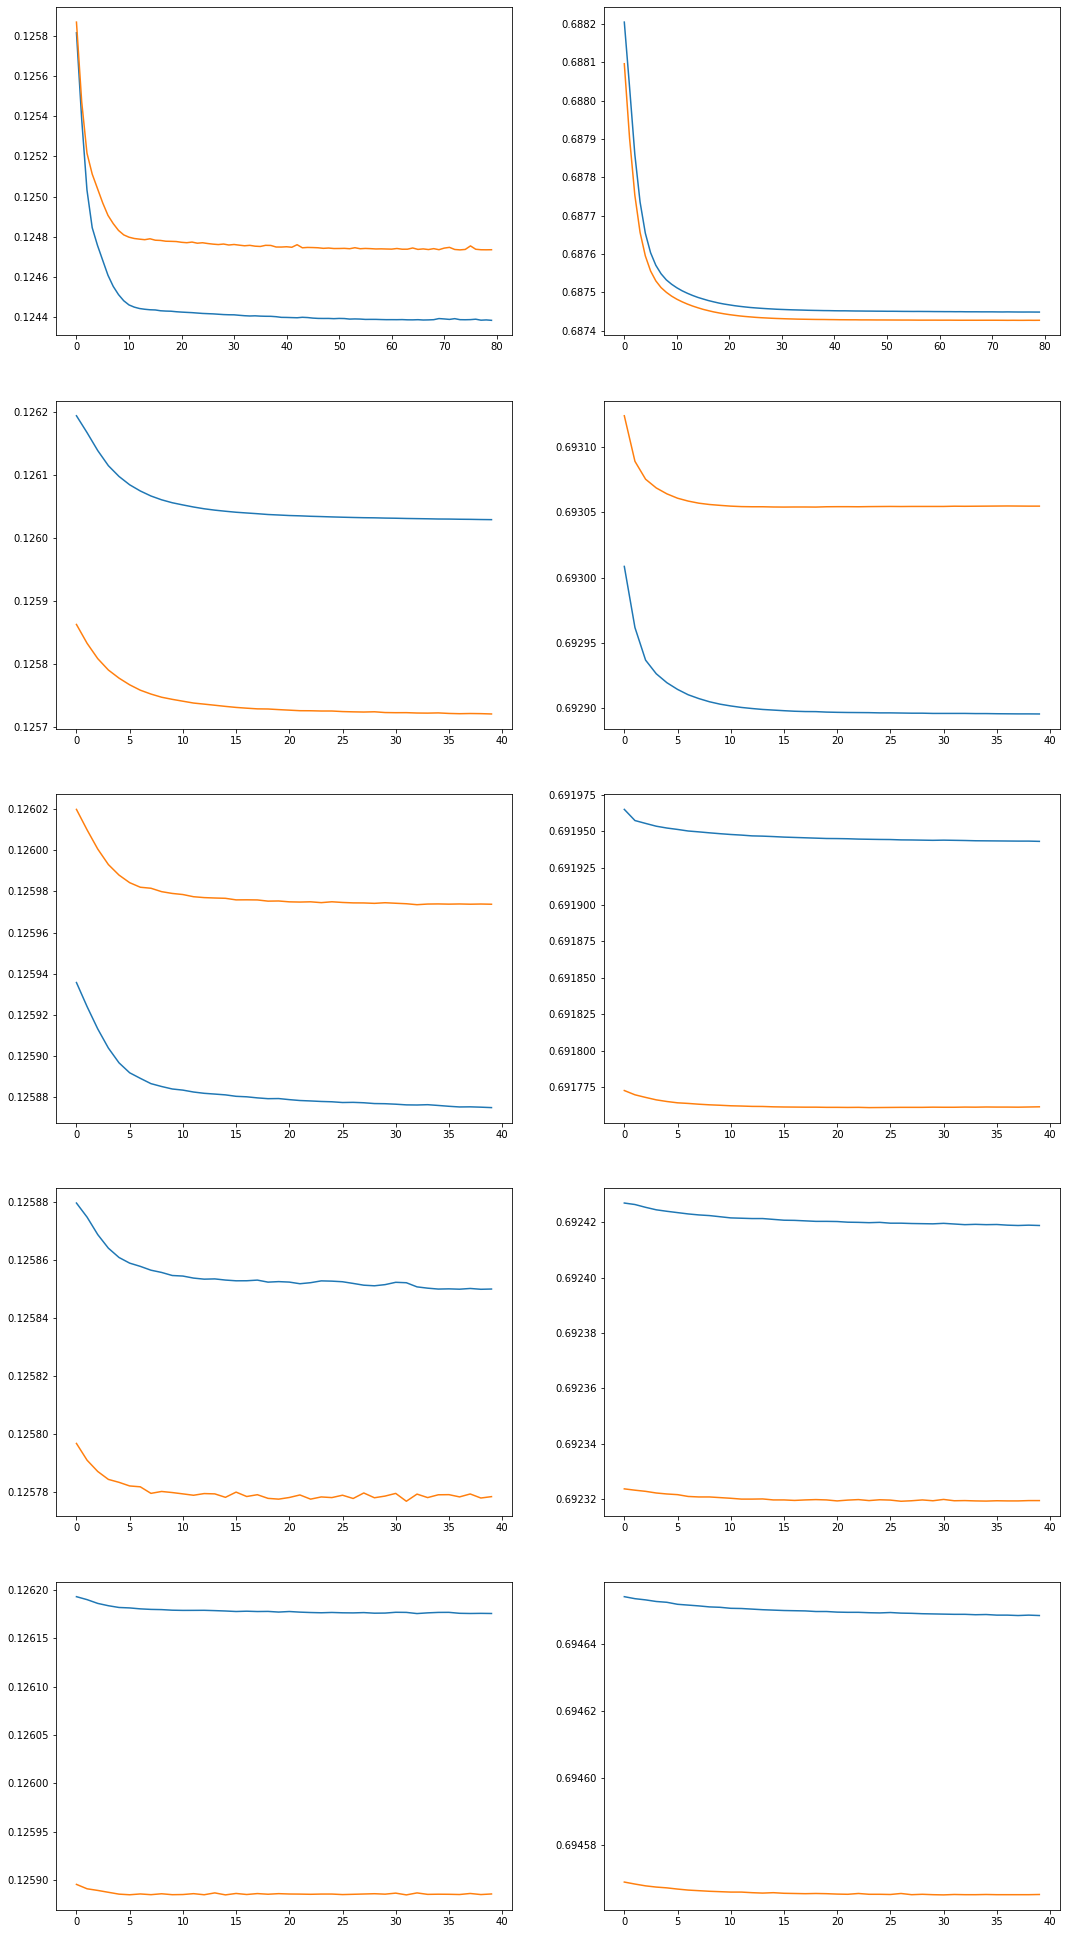

In [22]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

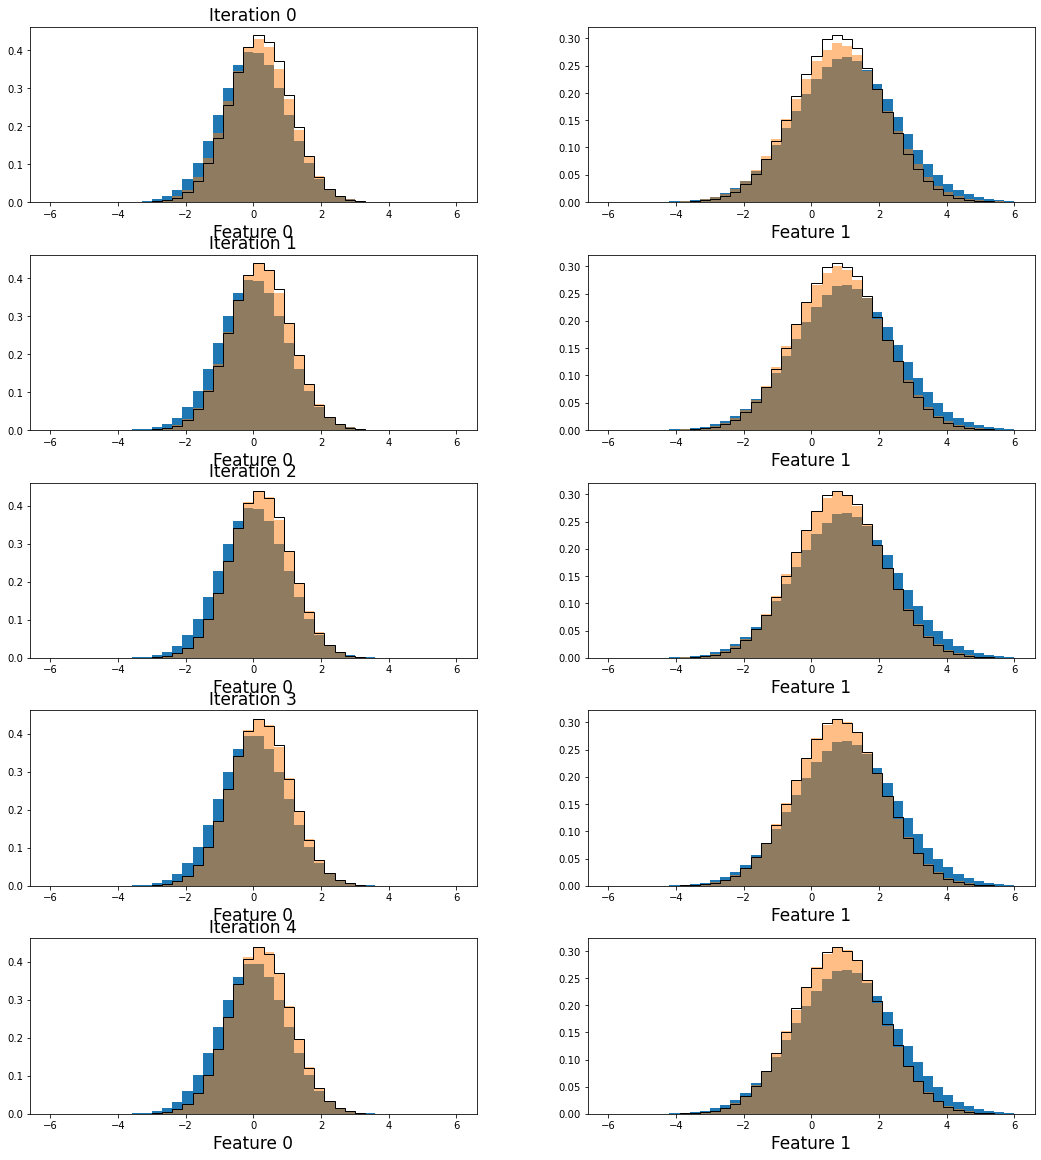

In [23]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [24]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

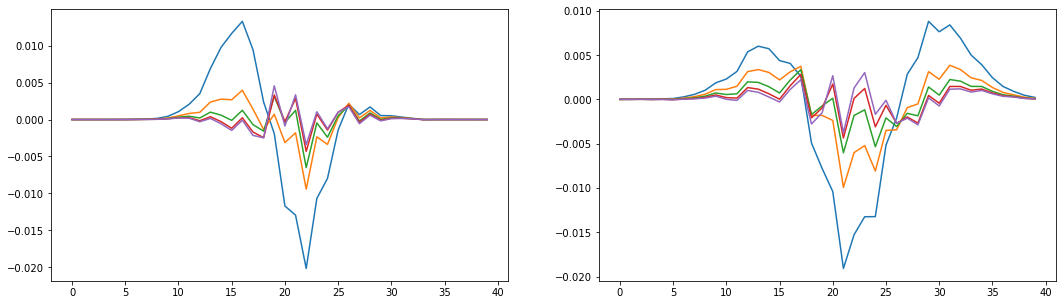

In [25]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

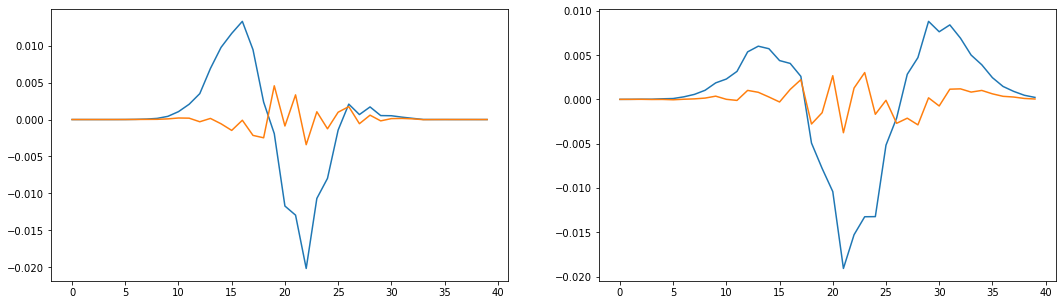

In [26]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

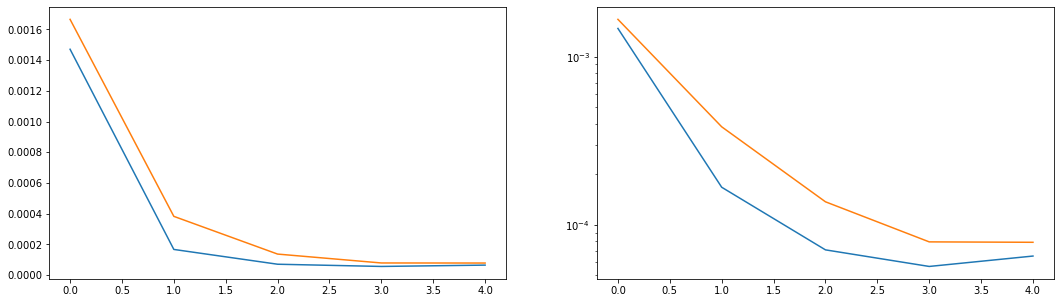

In [27]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

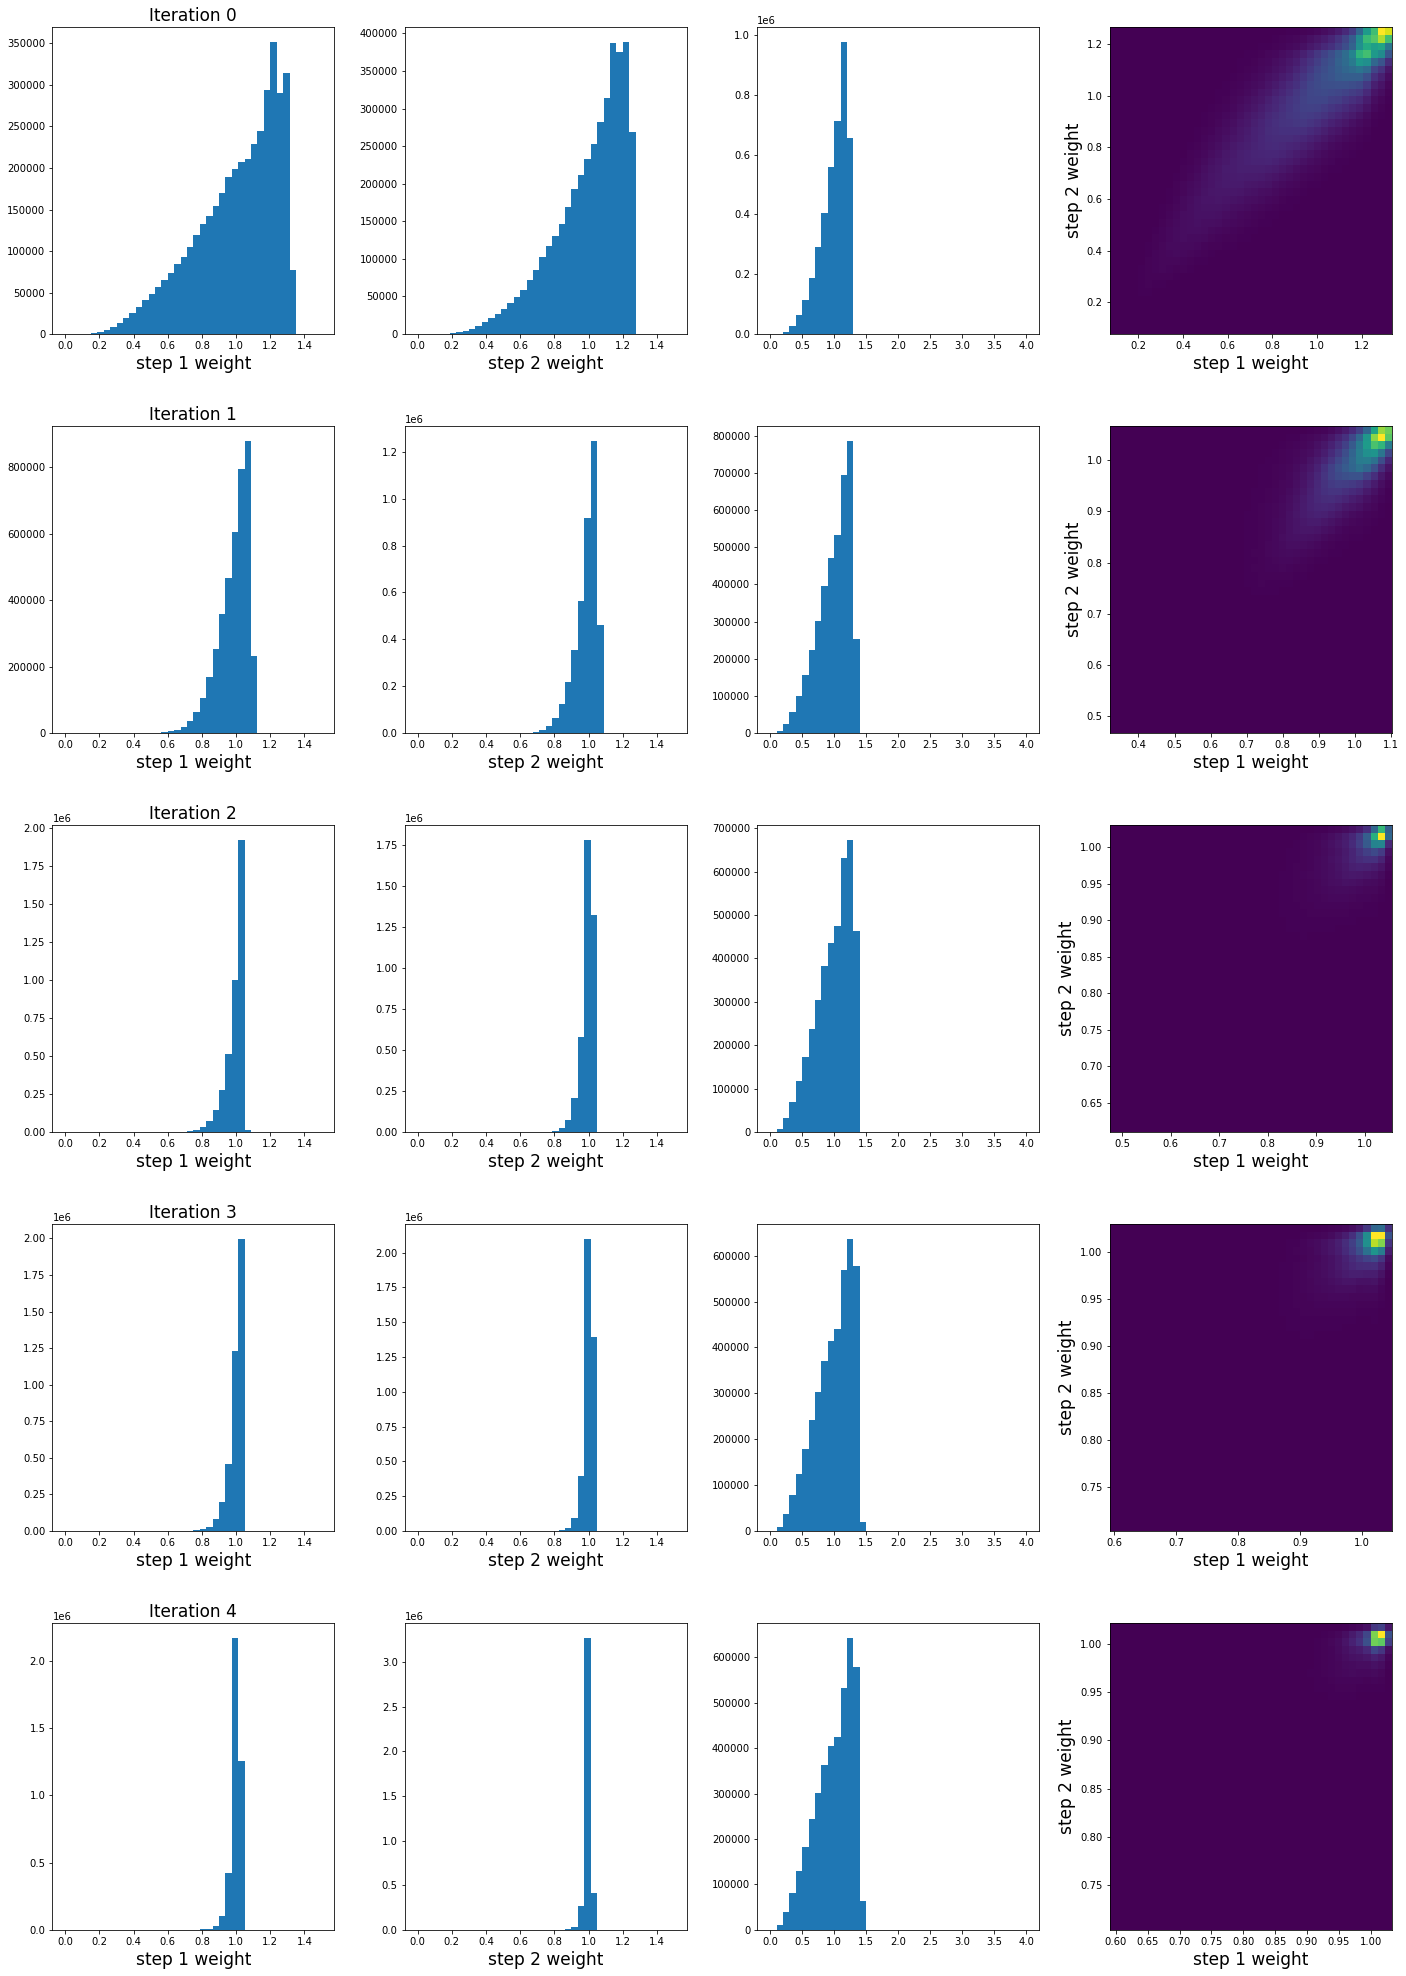

In [28]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,4.] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

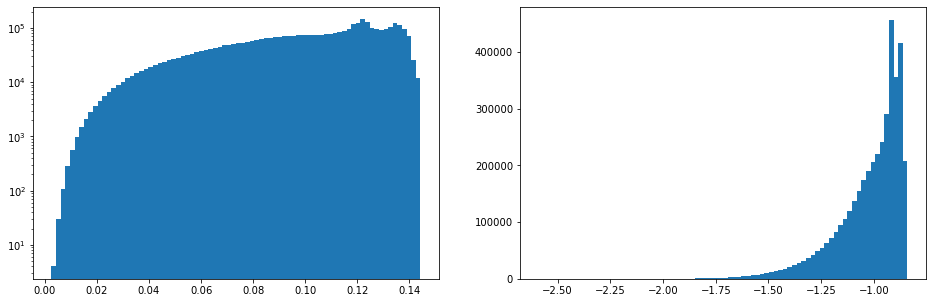

In [29]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

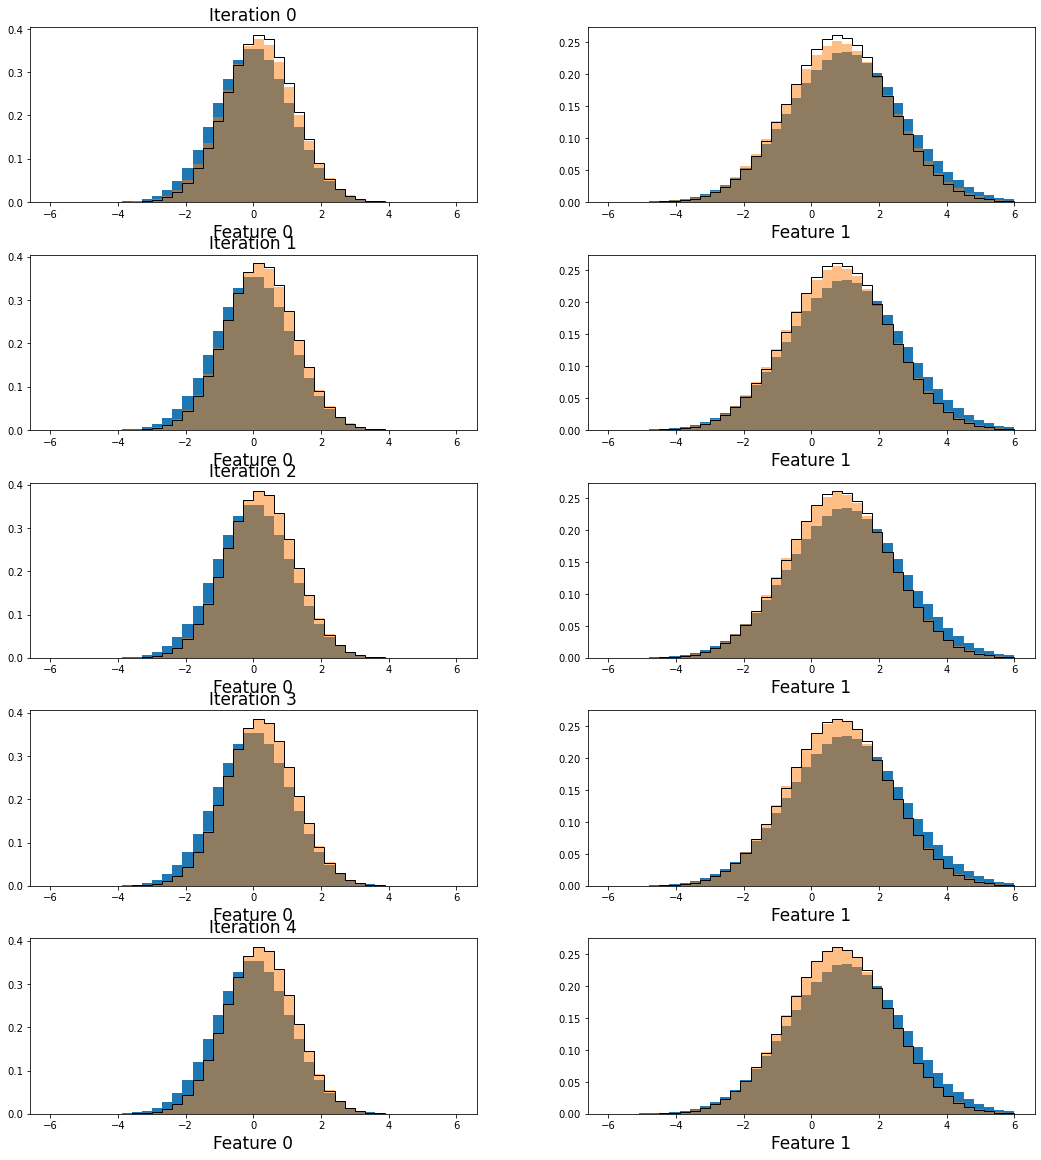

In [30]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [31]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

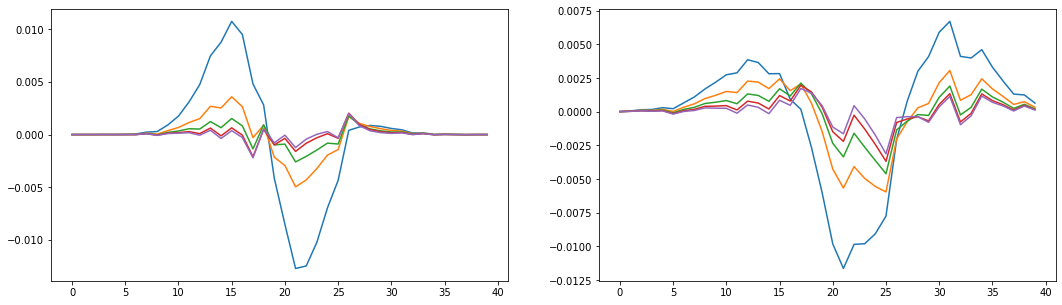

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

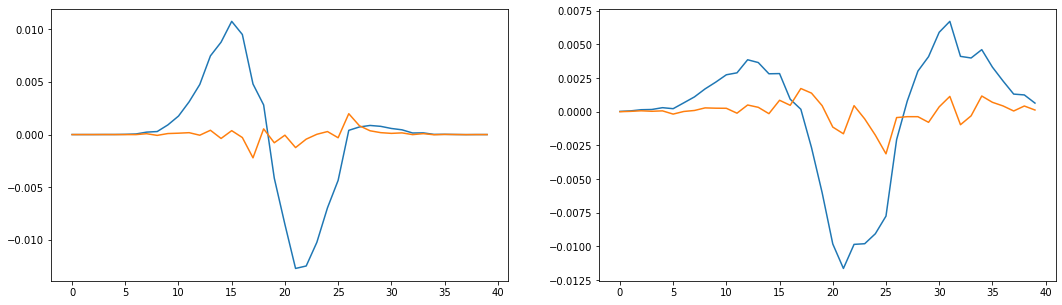

In [33]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

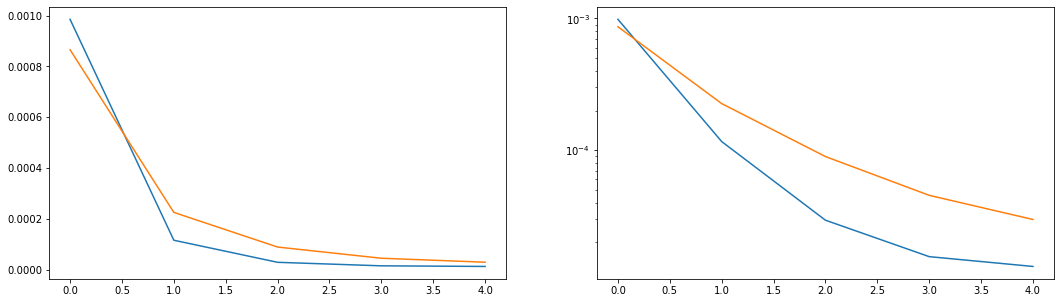

In [34]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [35]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.001  rms 0.243      step 2 mean  1.002  rms 0.206
  iter  1 : step 1 mean  0.986  rms 0.088      step 2 mean  0.985  rms 0.065
  iter  2 : step 1 mean  0.992  rms 0.053      step 2 mean  0.992  rms 0.034
  iter  3 : step 1 mean  0.999  rms 0.038      step 2 mean  1.000  rms 0.024
  iter  4 : step 1 mean  0.999  rms 0.026      step 2 mean  1.000  rms 0.016


<function matplotlib.pyplot.show(close=None, block=None)>

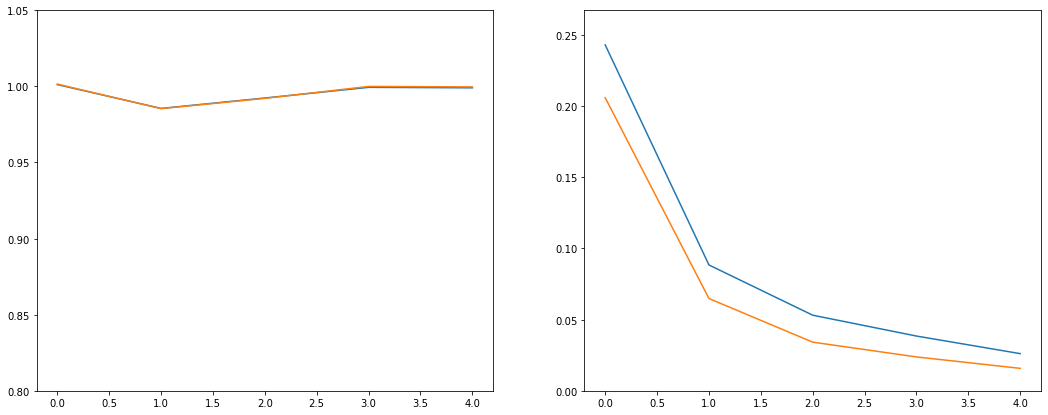

In [36]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show